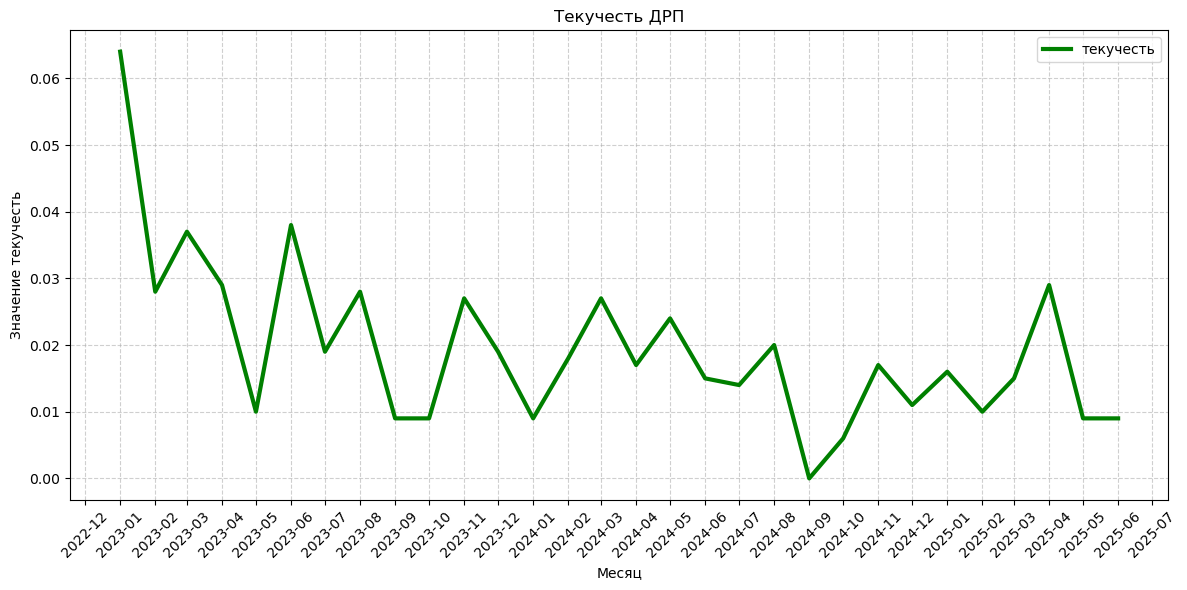

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


#ДЛЯ БАЗОВОЙ ПОДГОТОВКИ МОДЕЛИ

#ЗАВОДИМ ДАННЫЕ
df = pd.read_excel('turnover_drp.xlsx')
colums_list = df.columns.tolist()

df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['turnover'] = pd.to_numeric(df['turnover'], errors='coerce')

# СТРОИМ ГРАФИК
df = df.dropna(subset=['date', 'turnover']).set_index('date').asfreq('MS')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['turnover'], label='текучесть', linewidth=3, color = 'green')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('Текучесть ДРП')
ax.set_xlabel('Месяц'); ax.set_ylabel('Значение текучесть')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

In [90]:
# ФУНКЦИЯ ADF
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("РЯД НЕ СТАЦИОНАРЕН по ADF")
    else:
        print("РЯД СТАЦИОНАРЕН по ADF")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['turnover'], 'Counts')

from statsmodels.tsa.stattools import kpss

# ФУНКЦИЯ KPSS
def test_stationarity_kpss(series, title=''):
    print(f"Results of KPSS Test on {title}:")
    result = kpss(series, regression='c', nlags="auto")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
    if result[1] < 0.05:
        print("РЯД НЕ СТАЦИОНАРЕН KPSS")
    else:
        print("РЯД СТАЦИОНАРЕН KPSS")
    
    for key, value in result[3].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

# пример вызова
test_stationarity_kpss(df['turnover'], 'Counts')

Results of ADF Test on Counts:
ADF Statistic: -1.726581933975204
p-value: 0.41747131407060345
РЯД НЕ СТАЦИОНАРЕН по ADF
Critical Value (1%): -3.7883858816542486
Critical Value (5%): -3.013097747543462
Critical Value (10%): -2.6463967573696143


Results of KPSS Test on Counts:
KPSS Statistic: 0.6954472122899841
p-value: 0.013959344337274174
РЯД НЕ СТАЦИОНАРЕН KPSS
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739




In [92]:
train_size = int(len(df) * 0.80)

train = df.iloc[:train_size]   # 
test  = df.iloc[train_size:]   # 

print("Размер train:", train.shape)
print("Размер test :", test.shape)

Размер train: (24, 1)
Размер test : (6, 1)


ADF p-value после 1 diff: 0.019885887054689654
Results of ADF Test on Train after 1st diff:
ADF Statistic: -3.2017104124851627
p-value: 0.019885887054689654
РЯД СТАЦИОНАРЕН по ADF
Critical Value (1%): -4.01203360058309
Critical Value (5%): -3.1041838775510207
Critical Value (10%): -2.6909873469387753




<Axes: xlabel='date'>

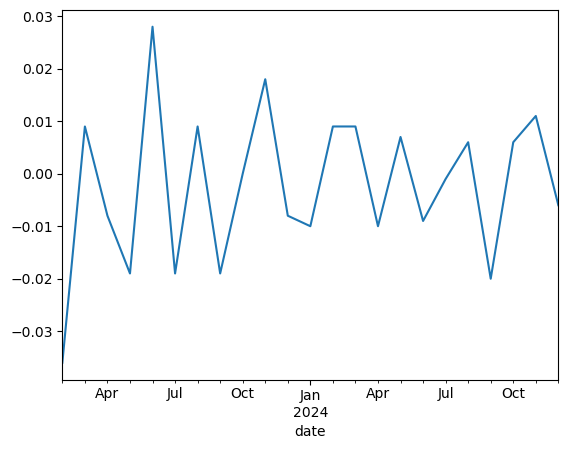

In [94]:
train_diff1 = train["turnover"].diff().dropna()

print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

train_diff1.plot()

<Figure size 800x400 with 0 Axes>

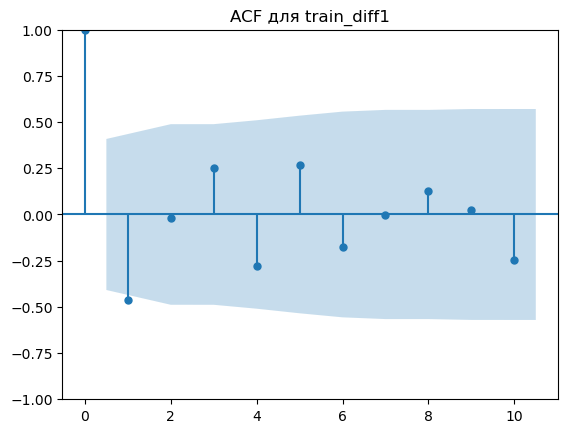

In [96]:
plt.figure(figsize=(8,4))
plot_acf(train_diff1, lags=10)
plt.title("ACF для train_diff1")
plt.show()

<Figure size 800x400 with 0 Axes>

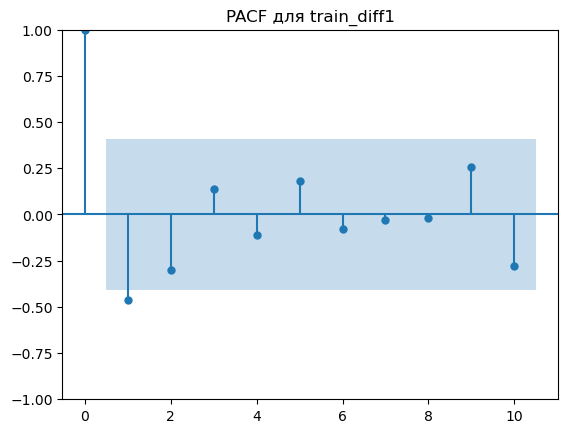

In [98]:
plt.figure(figsize=(8,4))
plot_pacf(train_diff1, lags=10, method="ywm")  # "ywm" – более устойчивая оценка
plt.title("PACF для train_diff1")
plt.show()

## ARIMA (базовая)

--------------------
--------------------
                               SARIMAX Results                                
Dep. Variable:               turnover   No. Observations:                   24
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  62.961
Date:                Sun, 21 Sep 2025   AIC                           -119.921
Time:                        22:38:58   BIC                           -116.648
Sample:                    01-01-2023   HQIC                          -119.150
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5593      0.287     -1.949      0.051      -1.122       0.003
ma.L1         -0.8843      0.395     -2.241      0.025      -1.658      -0.111
sigma2    

C:\Users\eugen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


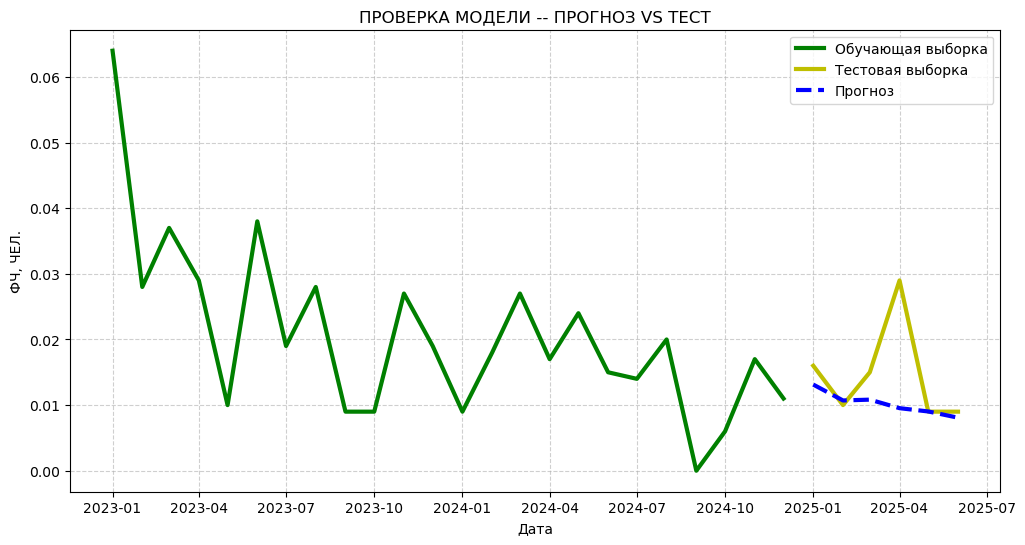

In [100]:
p = 1
d = 2
q = 1

model = ARIMA(train["turnover"], order=(p, d, q))
print('--------------------')
model_fit = model.fit()
print('--------------------')
print(model_fit.summary())

#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["turnover"] - forecast) / test["turnover"])) * 100
print('--------------------')
print(f"MAPE: {mape:.2f}%")

#проверка MAE
y_true = test["turnover"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print('--------------------')
print(f"MAE: {mae:.2f}")

#печать прогнозных значений
forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print('--------------------')
print (forecast)

plt.figure(figsize=(12,6))
plt.plot(train.index, train["turnover"], label="Обучающая выборка", linewidth=3, color="green")
plt.plot(test.index, test["turnover"], label="Тестовая выборка", linewidth=3, color="y")
plt.plot(test.index, forecast, label="Прогноз", linewidth=3, linestyle='--', color="blue")

plt.title("ПРОВЕРКА МОДЕЛИ -- ПРОГНОЗ VS ТЕСТ")
plt.xlabel("Дата")
plt.ylabel("ФЧ, ЧЕЛ.")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## ARIMA (прогноз)

In [ ]:
p = 1
d = 2
q = 1

model = ARIMA(df["turnover"], order=(p, d, q))
model_fit = model.fit()
print('--------------------')
print(model_fit.summary())

s = pd.to_numeric(df["turnover"], errors="coerce").dropna() 
s.index = pd.to_datetime(df.index) # если уже datetime — ок 
freq = pd.infer_freq(s.index) 
if freq is None: 
    freq = "MS" 
s = s.asfreq(freq).interpolate() 

model = ARIMA(s, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False) 
model_fit = model.fit()
print('----------------') 
print(model_fit.summary())

fc = model_fit.get_forecast(steps=12) 
yhat = fc.predicted_mean # значения прогноза ci = fc.conf_int() # доверительные интервалы

#print("\nПрогноз на 12 периодов:") 
#print(yhat)

plt.figure(figsize=(12,6)) 
plt.plot(s.index, s.values, label="Факт", linewidth=3, color = 'green') 
plt.plot(yhat.index, yhat.values, label="Прогноз (12)", linewidth=3, color = 'blue', linestyle='--') 

plt.title("ПРОГНОЗ --БАЗОВАЯ ARIMA") 
plt.xlabel("Дата"); 
plt.ylabel("ФЧ, ЧЕЛ.") 
plt.legend(); 
plt.grid(True, linestyle="--", alpha=0.6) 
plt.show()